We use the uniform distribution for analytical find the conditionary expectation of profit

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import scipy.optimize 

In [2]:
def expectedProfit_montecarlo(distr, params, C, f, S, sigma2, n = 20000):
    answ = 0
    for i in range(n):
        cc = np.abs(distr(*params))
        answ -= f
        if cc>= sigma2:
            answ += S * 1/8*(sigma2-cc)**2
    return answ/n

In [3]:
C = np.random.uniform(1,2, size = 100)
expectedProfit_montecarlo(np.random.uniform, (1,2), C, 0.01, 1, 1.5)

-0.004678354632637814

In [4]:
a = 1
b = 2

C = np.random.uniform(a,b, size = 10000)
C2 = [x*x for x in C]
print(np.mean(C2))
print(1/3 * (b-a)**2 + a*(b-a) + a**2)

sigma2 = 1.5
print((1/3*(b-sigma2)**2 + sigma2*(b-sigma2) + sigma2**2)*0.5)

answ = 0
for x in C:
    if x >= sigma2:
        answ += x**2
print(answ/10000)

2.341755984398131
2.333333333333333
1.5416666666666667
1.5543581301021432


In [5]:
f = 0.01

P = 1/8*(sigma2**2 - sigma2 * (sigma2+b) +  (1/3*(b-sigma2)**2 + sigma2*(b-sigma2) + sigma2**2))*(b-sigma2)/(b-a)-f
print(P)

-0.004791666666666658


In [6]:
class ApsundNokeModel():
    def __init__(self, distr, data, n_depth = 20000):
        self.distr = distr
        self.setData(data)
        self.n_depth = n_depth
    
    def setData(self, data):
        self.data = data
        self.n_epochs = data.shape[0]
        self.k_params = 0
        for x in self.data.columns:
            if x[0:5] == "param":
                self.k_params+=1

    def getParams(self, epoch):
        params = (self.data[f"param_0"][epoch],)
        for i in range(1, self.k_params):
            params += (self.data[f"param_{i}"][epoch],)
        return params
        
    
    def Sigma2(self, C, epoch):
        sigma = self.data["sigma"][epoch]
        return (1+sigma*np.sum(C))/(1+sigma*len(C))
    
    def expectedProfit_montecarlo(self, C, epoch):
        f = self.data["f"][epoch]
        S = self.data["S"][epoch]
        params = self.getParams(epoch)
        n = self.n_depth
        sigma2 = self.Sigma2(C, epoch)
        if self.distr == np.random.uniform:
            a, b = params[0], params[1]
            if sigma2 > b:
                return S*0.125*(sigma2**2-sigma2*(b+a)+1/3*(b**2+b*a+a**2))-f
            if sigma2 < a:
                return -f
            return S * 1/24*(sigma2-a)**3/(b-a)-f

        answ = 0
        for i in range(n):
            cc = np.abs(self.distr(*params))
            answ -= f
            if cc<= sigma2:
                answ += S * 1/8*(sigma2-cc)**2
        return answ/n

    def NPV_for_entrant(self, C, epoch):
        r = self.data["r"][epoch]
        return ((1+r)/r) * self.expectedProfit_montecarlo(C, epoch)
    
    def scenario(self, out = False):
        #data prepare
        NPV_ent = [0] * self.n_epochs
        M = [0] * self.n_epochs
        P_mean = [0] * self.n_epochs
        EP_ = [0] * self.n_epochs
        C_mean = [0] * self.n_epochs
        C_min = [0] * self.n_epochs
        C_max = [0] * self.n_epochs
        Sigma2 = [0] * self.n_epochs
        M_ent = [0] * self.n_epochs
        M_ex = [0] * self.n_epochs

        #zero epoch
        params = self.getParams(0)
        C = np.abs(self.distr(*params, size = 1000))
        
        for epoch in range(self.n_epochs):
            #loading data
            params = self.getParams(epoch)
            f = self.data["f"][epoch]
            r = self.data["r"][epoch]
            ef = self.data["ef"][epoch]
            alpha = self.data["alpha"][epoch]
            S = self.data["S"][epoch]

            NPV1 = self.NPV_for_entrant(C, epoch)
            EP = self.expectedProfit_montecarlo(C, epoch)

            #entrance stage
            n_ent = 0
            while NPV1 > ef:
                c = np.abs(self.distr(*params, size = 1))
                C = np.append(C, c)
                n_ent += 1
                NPV1 = self.NPV_for_entrant(C, epoch)


                
            #recounting stage
            for i in range(len(C)):
                a = random.random()
                if a > alpha:
                    C[i] = np.abs(self.distr(*params))
            
            # sort of C
            C = np.flip(np.sort(C))

            # exit stage
            EP = self.expectedProfit_montecarlo(C, epoch)
            sigma2 = self.Sigma2(C, epoch)
            n_ex = 0
            i = 0
            P_fact = []
            while (i < len(C)):
                P = - f
                if sigma2 > C[i]:
                    P = S * 1/8*(sigma2 - C[i])**2 - f
                P_fact.append(P)
                NPV2 = (1+r)/(1+r-alpha) * P + (1/r - alpha/(1+r-alpha))*EP
                if NPV2 < 0:
                    C = np.delete(C, i)
                    n_ex += 1
                    EP = self.expectedProfit_montecarlo(C, epoch)
                    sigma2 = self.Sigma2(C, epoch)
                else:
                    i += 1
                
            NPV_ent[epoch] = NPV1
            M[epoch] = len(C)
            P_mean[epoch] = np.mean(P_fact)
            EP_[epoch] = EP
            C_mean[epoch] = np.mean(C)
            C_min[epoch] = np.min(C)
            C_max[epoch] = np.max(C)
            Sigma2[epoch] = sigma2
            M_ent[epoch] = n_ent
            M_ex[epoch] = n_ex

            if out:
                print(f"epoch{epoch}, number of firms: {M[epoch]}, entrats: {M_ent[epoch]}, exiters: {M_ex[epoch]}, EP: {EP_[epoch]}, C_mean: {C_mean[epoch]}, EP_fact: {P_mean[epoch]}")
        
        self.data["NPV_ent"] = NPV_ent
        self.data["n_firms"] = M
        self.data["Pr_mean"] = P_mean
        self.data["EP"] = EP_
        self.data["C_mean"] = C_mean
        self.data["C_min"] = C_min
        self.data["C_max"] = C_max
        self.data["Sigma2"] = Sigma2
        self.data["n_entr"] = M_ent
        self.data["n_ext"] = M_ex

    def getData(self):
        return self.data

In [7]:
#parameters of distribution
Ec = 2
Dc = 0.04
scale = Dc**0.5

#parameters of utility
sigma = 0.5
S = 4

#parameters of firms
f = 0.001 # fixed costs
ef = 0.001 # entrance costs
r = 0.02 #return of interest
alpha = 0.3
a=0.8
b=1

n = 5000

data = {"param_0": [a]*n,
        "param_1": [b]*n,
        "sigma": [sigma]*n,
        "S": [S]*n,
        "f": [f]*n,
        "ef": [ef]*n,
        "r": [r]*n,
        "alpha": [alpha]*n}

df = pd.DataFrame(data)
df

,param_0,param_1,sigma,S,f,ef,r,alpha
0,0.8,1,0.5,4,0.001,0.001,0.02,0.3
1,0.8,1,0.5,4,0.001,0.001,0.02,0.3
2,0.8,1,0.5,4,0.001,0.001,0.02,0.3
3,0.8,1,0.5,4,0.001,0.001,0.02,0.3
4,0.8,1,0.5,4,0.001,0.001,0.02,0.3
...,...,...,...,...,...,...,...,...
4995,0.8,1,0.5,4,0.001,0.001,0.02,0.3
4996,0.8,1,0.5,4,0.001,0.001,0.02,0.3
4997,0.8,1,0.5,4,0.001,0.001,0.02,0.3
4998,0.8,1,0.5,4,0.001,0.001,0.02,0.3


In [8]:
Noke = ApsundNokeModel(distr = np.random.uniform,
                       data = df)

In [9]:
Noke.scenario(out=True)

epoch0, number of firms: 1, entrats: 0, exiters: 999, EP: 0.0009758313735364491, C_mean: 0.8000352812683658, EP_fact: -0.0009711905390992237
epoch1, number of firms: 3, entrats: 2, exiters: 0, EP: 0.0009804864720734567, C_mean: 0.8890828881076499, EP_fact: 0.0012124029224978448
epoch2, number of firms: 2, entrats: 3, exiters: 4, EP: 0.00022205996496534063, C_mean: 0.827224200103923, EP_fact: 0.0006665728231668022
epoch3, number of firms: 4, entrats: 2, exiters: 0, EP: 0.00022763640281229874, C_mean: 0.8706769710878365, EP_fact: 0.0010700002131776528
epoch4, number of firms: 21, entrats: 17, exiters: 0, EP: 0.00037903915264316597, C_mean: 0.9104995187414369, EP_fact: -0.00010764867251456313
epoch5, number of firms: 29, entrats: 8, exiters: 0, EP: 0.00034842278814829677, C_mean: 0.9117037409739381, EP_fact: -9.352296383159534e-05
epoch6, number of firms: 2, entrats: 9, exiters: 36, EP: -6.381463673328365e-05, C_mean: 0.80791110821446, EP_fact: -0.000591503815467947
epoch7, number of firm

In [10]:
result = Noke.getData()
result

,param_0,param_1,sigma,S,f,ef,r,alpha,NPV_ent,n_firms,Pr_mean,EP,C_mean,C_min,C_max,Sigma2,n_entr,n_ext
0,0.8,1,0.5,4,0.001,0.001,0.02,0.3,-0.004944,1,-0.000971,0.000976,0.800035,0.800035,0.800035,0.933345,0,999
1,0.8,1,0.5,4,0.001,0.001,0.02,0.3,-0.020785,3,0.001212,0.000980,0.889083,0.845175,0.962664,0.933450,2,0
2,0.8,1,0.5,4,0.001,0.001,0.02,0.3,-0.004838,2,0.000667,0.000222,0.827224,0.826887,0.827561,0.913612,3,4
3,0.8,1,0.5,4,0.001,0.001,0.02,0.3,-0.014659,4,0.001070,0.000228,0.870677,0.811242,0.943345,0.913785,2,0
4,0.8,1,0.5,4,0.001,0.001,0.02,0.3,0.000027,21,-0.000108,0.000379,0.910500,0.803730,0.998505,0.918282,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.8,1,0.5,4,0.001,0.001,0.02,0.3,-0.020795,3,0.002642,0.000635,0.875295,0.805302,0.981902,0.925177,2,0
4996,0.8,1,0.5,4,0.001,0.001,0.02,0.3,-0.002256,2,0.000876,0.000125,0.821067,0.808338,0.833796,0.910533,2,3
4997,0.8,1,0.5,4,0.001,0.001,0.02,0.3,-0.014381,3,0.002741,0.000676,0.877060,0.808338,0.989046,0.926236,1,0
4998,0.8,1,0.5,4,0.001,0.001,0.02,0.3,-0.002249,2,-0.000171,-0.000025,0.810766,0.808338,0.813194,0.905383,15,16


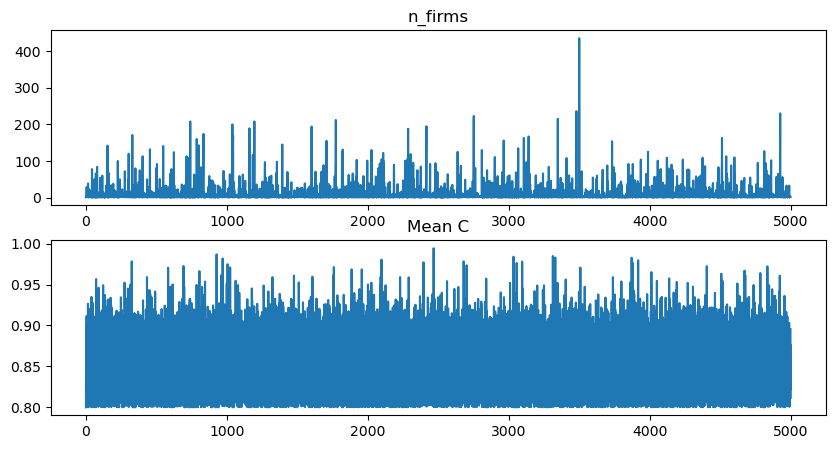

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result["n_firms"])
plt.subplot(2,1,2)
plt.title('Mean C')
plt.plot(result["C_mean"])

In [12]:
m=result["n_firms"].mean()
sigma_est=result["Sigma2"].mean()
c_max=result["C_max"].mean()
sigma_est,m,c_max

(0.923619354367098, 10.4972, 0.9027550975698687)

In [13]:
#x0 - sigma2entrant
#x1 - sigma2exit
#x2 - m
#x3 - c^

def fun(x):
    
    global sigma,S,f,ef,r,alpha,a,b

    y = [x[0]-(1+sigma*x[2]/2*(x[3]+a))/(1+sigma*x[2]),
        x[1]-(1+sigma*(alpha*x[2]/2*(x[3]+a)+(1-alpha)*x[2]/2*(b+a)))/(1+sigma*x[2]),
        (1+r)/r*(S/8*(x[0]-a)**3/(b-a)-f)-ef,
        (1+r)/(1+r-alpha)*(S/8*(x[1]-x[3])**2-f)+(1/r-alpha/(1+r-alpha))*(S/8*(x[1]-a)**3/(b-a)-f)]
    return y

In [14]:
x0 = scipy.optimize.fsolve(fun,[1,1,1,1], maxfev=1000)
x0,fun(x0)

D:\conda\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(array([8.73103389e-01, 8.76328086e-01, 7.13971966e+05, 9.35519488e-01]),
 [0.005343275149445659,
  -0.0140001448331466,
  -0.002189290908421526,
  0.006604223495409544])

In [15]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [18]:
def optimacros(start,stop,step):
    global m,k
    for i in frange(start,stop,step):
        for j in frange(start,stop,step):
            for k in frange(start,stop,step):
                for z in frange(start,stop,step):
                    x0 = scipy.optimize.fsolve(fun,[i,j,k,z], maxfev=1000)
                    if x0[2]>(m-0.25) and x0[2]<(m+0.25):
                        return(x0)    

In [19]:
optimacros(0,10,0.5)

array([ 0.99744231,  1.93735006, 10.28523827,  1.36827639])